# 07 VAR Forecast

In [20]:
import pandas as pd
from pandas import DataFrame, Series
from numpy import ndarray

from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [21]:
# Show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# widen the column width and overall display width
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

In [22]:
TRAIN_PATH: str = "../data/interim/train.csv"
FORECAST_PATH: str = "../data/interim/forecast.csv"
TARGET_COL: str = "use_house_overall"
MAX_LAG_CAP: int = 24

In [23]:
train_df: DataFrame = pd.read_csv(TRAIN_PATH, index_col="time", parse_dates=True)
forecast_df: DataFrame = pd.read_csv(FORECAST_PATH, index_col="time", parse_dates=True)

# Select only numeric columns
train_df = train_df.select_dtypes(include="number")
forecast_df = forecast_df[train_df.columns]

In [24]:
# Drop constant columns
constant_cols = train_df.columns[train_df.nunique() <= 1]
if not constant_cols.empty:
    print(f"Dropping constant columns: {list(constant_cols)}")
    train_df = train_df.drop(columns=constant_cols)
    forecast_df = forecast_df.drop(columns=constant_cols)

Dropping constant columns: ['year', 'minute']


In [25]:
model: VAR = VAR(train_df)

n_obs: int = train_df.shape[0]
k_vars: int = train_df.shape[1]
safe_max_lag: int = max(1, min(MAX_LAG_CAP, n_obs // k_vars - 1))

print(f"Using safe maxlag: {safe_max_lag}")

selected_order: DataFrame = model.select_order(maxlags=safe_max_lag)
best_lag: int = selected_order.aic

print(f"Selected best lag based on AIC: {best_lag}")

fitted_model = model.fit(best_lag)

Using safe maxlag: 3
Selected best lag based on AIC: 3


MAE (use_house_overall): 0.6263


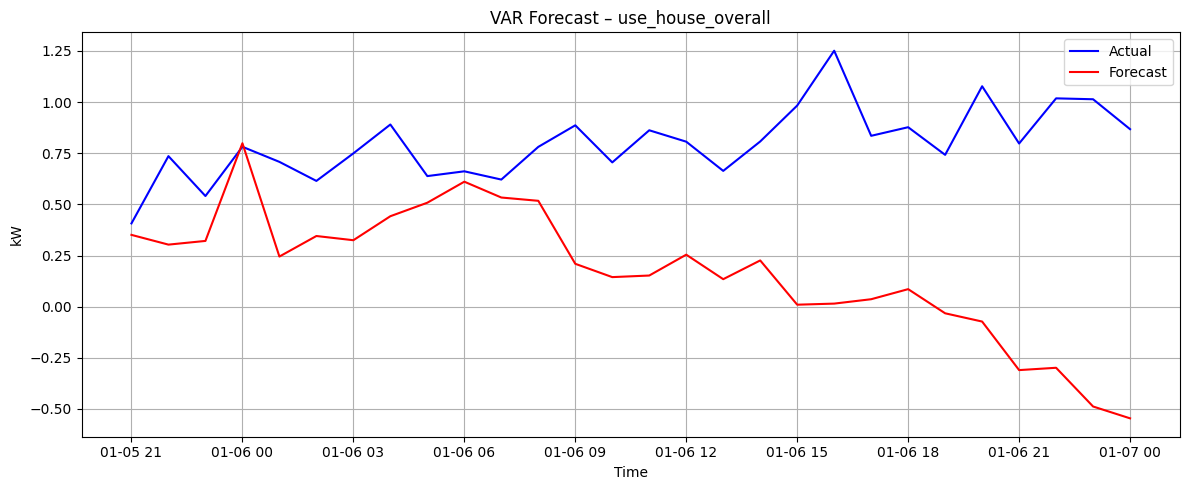

In [26]:
n_forecast: int = len(forecast_df)
last_values: ndarray = train_df.values[-best_lag:]
forecast_values: ndarray = fitted_model.forecast(last_values, steps=n_forecast)

forecast_df_pred: DataFrame = pd.DataFrame(forecast_values, columns=train_df.columns, index=forecast_df.index)

if TARGET_COL in forecast_df.columns:
    actual: Series = forecast_df[TARGET_COL]
    predicted: Series = forecast_df_pred[TARGET_COL]
    mae: float = mean_absolute_error(actual, predicted)
    print(f"MAE ({TARGET_COL}): {mae:.4f}")

    plt.figure(figsize=(12, 5))
    plt.plot(actual, label="Actual", color="blue")
    plt.plot(predicted, label="Forecast", color="red")
    plt.title(f"VAR Forecast – {TARGET_COL}")
    plt.xlabel("Time")
    plt.ylabel("kW")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Column '{TARGET_COL}' not found in forecast data.")

We trained a Vector AutoRegression (VAR) model on hourly energy and weather data to forecast use_house_overall. Despite basic preprocessing and automated lag selection (AIC-based), the model yields a mean absolute error (MAE) of 0.6263 kW over a 7-day horizon.